## **Importing Libraries**

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
import gensim
import gensim.corpora as corpora
from gensim.models import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re

## **Dataset Preparation**

In [2]:
train_dir = 'Train/'
test_dir = 'Test/'

def import_data(directory_path):
    try:
        all_filenames = os.listdir(directory_path)
        csv_files = [
            os.path.join(directory_path, filename) 
            for filename in all_filenames 
            if filename.endswith('.csv')
        ]
    except FileNotFoundError:
        print(f"Error: The directory '{directory_path}' was not found.")
        return None

    if not csv_files:
        print(f"Warning: No CSV files found in the directory: {directory_path}")
        return None

    list_of_dfs = []
    print(f"Found {len(csv_files)} CSV files to process...")

    for file_path in csv_files:
        try:
            temp_df = pd.read_csv(file_path)
            filename = os.path.basename(file_path)
            app_name = os.path.splitext(filename)[0]
            temp_df['App'] = app_name
            list_of_dfs.append(temp_df)
            print(f"  - Processed {filename} and added '{app_name}' as App.")
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    print("\nCombining all DataFrames...")
    combined_df = pd.concat(list_of_dfs, ignore_index=True)
    print("Done.")
    return combined_df

In [3]:
train = import_data(train_dir)

Found 6 CSV files to process...
  - Processed claude.csv and added 'claude' as App.
  - Processed deepseek.csv and added 'deepseek' as App.
  - Processed gemini.csv and added 'gemini' as App.
  - Processed gpt.csv and added 'gpt' as App.
  - Processed grok.csv and added 'grok' as App.
  - Processed perplexity.csv and added 'perplexity' as App.

Combining all DataFrames...
Done.


## **Function Declaration**

In [15]:
def run_chi_square_test(df, group_col='App', category_col='Sentiment'):
    print("--- 1. Chi-Square Test for Sentiment Distribution ---")
    
    contingency_table = pd.crosstab(df[group_col], df[category_col])
    print("Contingency Table (Observed Frequencies):")
    print(contingency_table)
    
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    print(f"\nChi-Square Statistic: {chi2:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    alpha = 0.05
    if p_value < alpha:
        print("\nInterpretation: Reject the null hypothesis.")
        print("Conclusion: There is a statistically significant association between the app and sentiment.")
        print("Now, running post-hoc tests to see which pairs of apps are different...")
        run_pairwise_chi_square(df, group_col, category_col)
    else:
        print("\nInterpretation: Fail to reject the null hypothesis.")
        print("Conclusion: There is no statistically significant association between the app and sentiment.")
    print("-" * 50)

def run_pairwise_chi_square(df, group_col, category_col):
    apps = df[group_col].unique()
    pairs = list(combinations(apps, 2))
    num_comparisons = len(pairs)
    bonferroni_alpha = 0.05 / num_comparisons
    
    print(f"\nPerforming {num_comparisons} pairwise comparisons with Bonferroni correction (alpha = {bonferroni_alpha:.4f})...")
    
    for pair in pairs:
        pair_df = df[df[group_col].isin(pair)]
        contingency = pd.crosstab(pair_df[group_col], pair_df[category_col])
        chi2, p, dof, expected = stats.chi2_contingency(contingency)
        
        if p < bonferroni_alpha:
            print(f"  - SIGNIFICANT difference found between {pair[0]} and {pair[1]} (p = {p:.4f})")
        else:
            print(f"  - No significant difference between {pair[0]} and {pair[1]} (p = {p:.4f})")


def run_anova_test(df, group_col='App', continuous_col='Comment'):
    print("\n--- 2. ANOVA Test for Average Comment Length ---")
    
    df['comment_length'] = df[continuous_col].str.len()
    
    unique_apps = df[group_col].unique()
    samples = []
    app_names_for_test = []
    for app in unique_apps:
        app_data = df['comment_length'][df[group_col] == app]
        if len(app_data) > 1:
            samples.append(app_data)
            app_names_for_test.append(app)
        else:
            print(f"Warning: Skipping app '{app}' from ANOVA test due to insufficient data (<= 1 sample).")

    if len(samples) < 2:
        print("\nCannot perform ANOVA: Need at least two groups with sufficient data.")
        print("-" * 50)
        return

    f_statistic, p_value = stats.f_oneway(*samples)
    
    print(f"\nF-Statistic: {f_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    alpha = 0.05
    if p_value < alpha:
        print("\nInterpretation: Reject the null hypothesis.")
        print("Conclusion: There is a statistically significant difference in the average comment length among the apps.")
        print("Now, running Tukey's HSD post-hoc test to see which pairs are different...")
        filtered_df = df[df[group_col].isin(app_names_for_test)]
        run_tukey_hsd_test(filtered_df, group_col, 'comment_length')
    else:
        print("\nInterpretation: Fail to reject the null hypothesis.")
        print("Conclusion: There is no statistically significant difference in the average comment length.")
    print("-" * 50)

def run_tukey_hsd_test(df, group_col, value_col):
    tukey_results = pairwise_tukeyhsd(endog=df[value_col], groups=df[group_col], alpha=0.05)
    print("\nTukey's HSD Results:")
    print(tukey_results)
    print("\nInterpretation: Look at the 'reject' column. If 'True', the difference between that pair of apps is statistically significant.")

def run_kruskal_wallis_test(df, group_col='App', continuous_col='Comment'):
    print("\n--- 4. Kruskal-Wallis Test for Comment Length (Non-parametric alternative to ANOVA) ---")
    
    if 'comment_length' not in df.columns:
        df['comment_length'] = df[continuous_col].str.len()

    unique_apps = df[group_col].unique()
    samples = []
    for app in unique_apps:
        app_data = df['comment_length'][df[group_col] == app]
        if len(app_data) > 1:
            samples.append(app_data)
        else:
            print(f"Warning: Skipping app '{app}' from Kruskal-Wallis test due to insufficient data (<= 1 sample).")

    if len(samples) < 2:
        print("\nCannot perform Kruskal-Wallis: Need at least two groups with sufficient data.")
        print("-" * 50)
        return
        
    h_statistic, p_value = stats.kruskal(*samples)

    print(f"\nH-Statistic: {h_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")

    alpha = 0.05
    if p_value < alpha:
        print("\nInterpretation: Reject the null hypothesis.")
        print("Conclusion: There is a statistically significant difference in the comment length distributions among the apps.")
    else:
        print("\nInterpretation: Fail to reject the null hypothesis.")
        print("Conclusion: There is no statistically significant difference in the comment length distributions.")
    print("-" * 50)


def plot_sentiment_trends(df, time_col='At', value_col='Sentiment', group_col='App'):
    print("\n--- 3. Sentiment Trend Visualization ---")
    
    weekly_sentiment = df.groupby(group_col).resample('W', on=time_col)[value_col].mean().reset_index()
    
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))
    
    sns.lineplot(
        data=weekly_sentiment,
        x=time_col,
        y=value_col,
        hue=group_col,
        marker='o'
    )
    
    plt.title('Weekly Average Sentiment Trend by App', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Average Sentiment Score', fontsize=12)
    plt.legend(title='App')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print("-" * 50)

def preprocess_for_lda(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A).lower().strip()
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 3]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

def perform_topic_modeling(df, app_name, comment_col='Comment', sentiment_col='Sentiment', num_topics=4):
    print(f"--- Performing Topic Modeling for Negative Reviews of '{app_name}' ---")
    
    app_df = df[(df['App'] == app_name) & (df[sentiment_col] == 0)].copy()
    
    if len(app_df) < num_topics:
        print(f"Warning: Not enough negative reviews for '{app_name}' to perform topic modeling. Skipping.")
        return

    # --- FIX: Ensure comment column is string and handle missing values ---
    app_df[comment_col] = app_df[comment_col].astype(str).fillna('')

    processed_docs = app_df[comment_col].map(preprocess_for_lda)
    
    id2word = corpora.Dictionary(processed_docs)
    corpus = [id2word.doc2bow(doc) for doc in processed_docs]
    
    print(f"\nTraining LDA model with {num_topics} topics...")
    
    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        random_state=100,
        chunksize=100,
        passes=10,
        per_word_topics=True
    )
    
    print("\n--- Identified Topics ---")
    topics = lda_model.print_topics()
    for topic in topics:
        print(topic)
        
    print("\n--- Generating Visualization ---")
    pyLDAvis.enable_notebook()
    vis = gensimvis.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
    
    return vis

def perform_topic_modeling_1(df, app_name, comment_col='Comment', sentiment_col='Sentiment', num_topics=4):
    print(f"--- Performing Topic Modeling for Negative Reviews of '{app_name}' ---")
    
    app_df = df[(df['App'] == app_name) & (df[sentiment_col] == 1)].copy()
    
    if len(app_df) < num_topics:
        print(f"Warning: Not enough negative reviews for '{app_name}' to perform topic modeling. Skipping.")
        return

    # --- FIX: Ensure comment column is string and handle missing values ---
    app_df[comment_col] = app_df[comment_col].astype(str).fillna('')

    processed_docs = app_df[comment_col].map(preprocess_for_lda)
    
    id2word = corpora.Dictionary(processed_docs)
    corpus = [id2word.doc2bow(doc) for doc in processed_docs]
    
    print(f"\nTraining LDA model with {num_topics} topics...")
    
    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        random_state=100,
        chunksize=100,
        passes=10,
        per_word_topics=True
    )
    
    print("\n--- Identified Topics ---")
    topics = lda_model.print_topics()
    for topic in topics:
        print(topic)
        
    print("\n--- Generating Visualization ---")
    pyLDAvis.enable_notebook()
    vis = gensimvis.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
    
    return vis

def perform_topic_modeling_2(df, app_name, comment_col='Comment', sentiment_col='Sentiment', num_topics=4):
    print(f"--- Performing Topic Modeling for Negative Reviews of '{app_name}' ---")
    
    app_df = df[(df['App'] == app_name) & (df[sentiment_col] == 2)].copy()
    
    if len(app_df) < num_topics:
        print(f"Warning: Not enough negative reviews for '{app_name}' to perform topic modeling. Skipping.")
        return

    # --- FIX: Ensure comment column is string and handle missing values ---
    app_df[comment_col] = app_df[comment_col].astype(str).fillna('')

    processed_docs = app_df[comment_col].map(preprocess_for_lda)
    
    id2word = corpora.Dictionary(processed_docs)
    corpus = [id2word.doc2bow(doc) for doc in processed_docs]
    
    print(f"\nTraining LDA model with {num_topics} topics...")
    
    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        random_state=100,
        chunksize=100,
        passes=10,
        per_word_topics=True
    )
    
    print("\n--- Identified Topics ---")
    topics = lda_model.print_topics()
    for topic in topics:
        print(topic)
        
    print("\n--- Generating Visualization ---")
    pyLDAvis.enable_notebook()
    vis = gensimvis.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
    
    return vis


def analyze_complaints_with_tfidf(dataframe, app_name='all'):
    if app_name != 'all':
        print(f"🔬 Analyzing negative reviews for: {app_name}")
        target_df = dataframe[dataframe['App'] == app_name].copy()
    else:
        print("🔬 Analyzing negative reviews for all apps combined.")
        target_df = dataframe.copy()

    negative_reviews_df = target_df[target_df['Sentiment'] == 0]
    
    if negative_reviews_df.empty:
        print("No negative reviews found for this selection.")
        return None

    def clean_text(text):
        text = str(text).lower()
        text = re.sub(r'[^a-z\s]', '', text)
        return text

    negative_reviews_df['cleaned_comment'] = negative_reviews_df['Comment'].apply(clean_text)

    vectorizer = TfidfVectorizer(
        stop_words='english', 
        max_features=1000,
        ngram_range=(1, 2)
    )
    
    tfidf_matrix = vectorizer.fit_transform(negative_reviews_df['cleaned_comment'])
    
    summed_tfidf = tfidf_matrix.sum(axis=0)
    
    feature_names = vectorizer.get_feature_names_out()
    
    results_df = pd.DataFrame(summed_tfidf.T, index=feature_names, columns=['score'])
    
    results_df = results_df.sort_values(by='score', ascending=False)
    
    return results_df



## **Analysis**

### **Chi-Square Test**

In [21]:
run_chi_square_test(train)

--- 1. Chi-Square Test for Sentiment Distribution ---
Contingency Table (Observed Frequencies):
Sentiment      0     1      2
App                          
claude      1421   439   4384
deepseek    3926   791  11340
gemini      6465  1733  26215
gpt         3139  1506  32397
grok        1453   561  22631
perplexity  1118   559  10807

Chi-Square Statistic: 5872.7565
P-value: 0.0000

Interpretation: Reject the null hypothesis.
Conclusion: There is a statistically significant association between the app and sentiment.
Now, running post-hoc tests to see which pairs of apps are different...

Performing 15 pairwise comparisons with Bonferroni correction (alpha = 0.0033)...
  - SIGNIFICANT difference found between claude and deepseek (p = 0.0000)
  - SIGNIFICANT difference found between claude and gemini (p = 0.0000)
  - SIGNIFICANT difference found between claude and gpt (p = 0.0000)
  - SIGNIFICANT difference found between claude and grok (p = 0.0000)
  - SIGNIFICANT difference found betwe

### **ANOVA Test**

In [22]:
run_anova_test(train)


--- 2. ANOVA Test for Average Comment Length ---

F-Statistic: nan
P-value: nan

Interpretation: Fail to reject the null hypothesis.
Conclusion: There is no statistically significant difference in the average comment length.
--------------------------------------------------


### **Tukey HSD Test**

In [23]:
run_tukey_hsd_test(train, 'App', 'comment_length')


Tukey's HSD Results:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1    group2   meandiff p-adj lower upper reject
-----------------------------------------------------
  claude   deepseek      nan   nan   nan   nan  False
  claude     gemini -53.7401   nan   nan   nan  False
  claude        gpt      nan   nan   nan   nan  False
  claude       grok   -61.05   nan   nan   nan  False
  claude perplexity      nan   nan   nan   nan  False
deepseek     gemini      nan   nan   nan   nan  False
deepseek        gpt      nan   nan   nan   nan  False
deepseek       grok      nan   nan   nan   nan  False
deepseek perplexity      nan   nan   nan   nan  False
  gemini        gpt      nan   nan   nan   nan  False
  gemini       grok  -7.3099   nan   nan   nan  False
  gemini perplexity      nan   nan   nan   nan  False
     gpt       grok      nan   nan   nan   nan  False
     gpt perplexity      nan   nan   nan   nan  False
    grok perplexity      nan   nan   nan   nan  False
------

### **Kruskal-Wallis Test**

In [24]:
run_kruskal_wallis_test(train)


--- 4. Kruskal-Wallis Test for Comment Length (Non-parametric alternative to ANOVA) ---

H-Statistic: nan
P-value: nan

Interpretation: Fail to reject the null hypothesis.
Conclusion: There is no statistically significant difference in the comment length distributions.
--------------------------------------------------


### **Sentiment Trends**


--- 3. Sentiment Trend Visualization ---


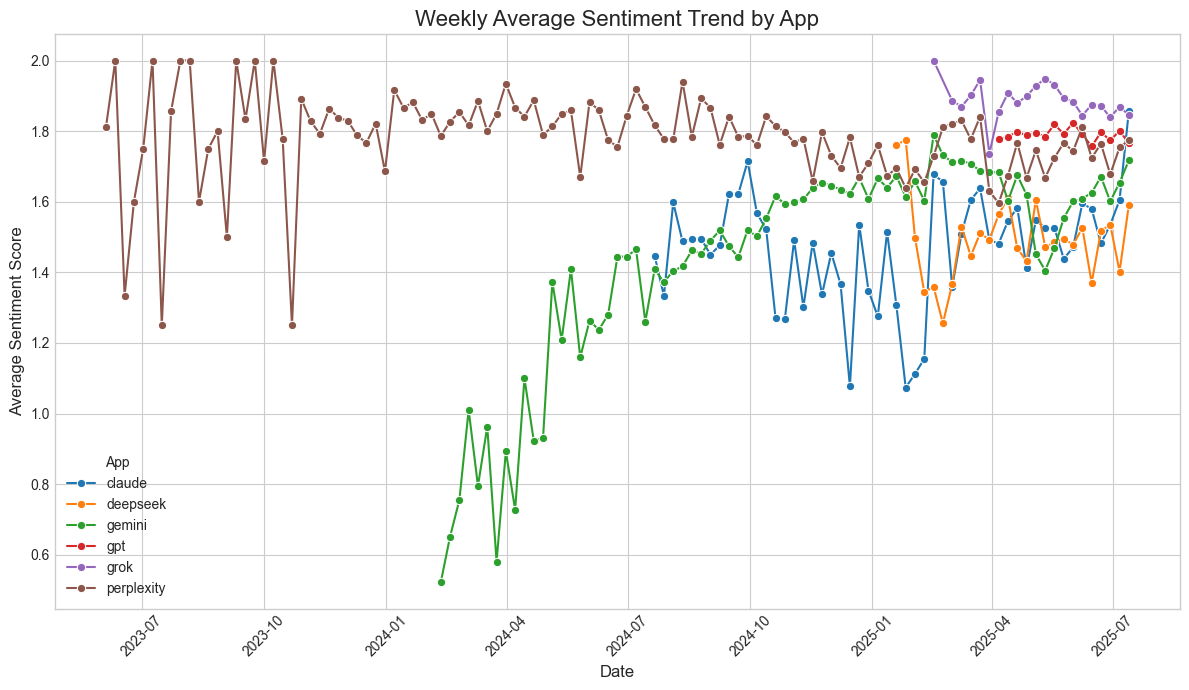

--------------------------------------------------


In [17]:
plot_sentiment_trends(train)

### **Topic Modelling - Label: 0**

In [36]:
if __name__ == '__main__':
    target_app1 = 'claude' 
    target_app2 = 'deepseek'
    target_app3 = 'gemini'
    target_app4 = 'gpt'
    target_app5 = 'grok'
    target_app6 = 'perplexity'
    lda_visualization1 = perform_topic_modeling(train, app_name=target_app1, num_topics=4)
    lda_visualization2 = perform_topic_modeling(train, app_name=target_app2, num_topics=4)
    lda_visualization3 = perform_topic_modeling(train, app_name=target_app3, num_topics=4)
    lda_visualization4 = perform_topic_modeling(train, app_name=target_app4, num_topics=4)
    lda_visualization5 = perform_topic_modeling(train, app_name=target_app5, num_topics=4)
    lda_visualization6 = perform_topic_modeling(train, app_name=target_app6, num_topics=4)
    # lda_visualization_2_1 = perform_topic_modeling_1(train, app_name=target_app1, num_topics=2)
    # lda_visualization_2_2 = perform_topic_modeling_1(train, app_name=target_app2, num_topics=2)
    # lda_visualization_2_3 = perform_topic_modeling_1(train, app_name=target_app3, num_topics=2)
    # lda_visualization_2_4 = perform_topic_modeling_1(train, app_name=target_app4, num_topics=2)
    # lda_visualization_2_5 = perform_topic_modeling_1(train, app_name=target_app5, num_topics=2)
    # lda_visualization_2_6 = perform_topic_modeling_1(train, app_name=target_app6, num_topics=2)
    # lda_visualization_3_1 = perform_topic_modeling_2(train, app_name=target_app1, num_topics=2)
    # lda_visualization_3_2 = perform_topic_modeling_2(train, app_name=target_app2, num_topics=2)
    # lda_visualization_3_3 = perform_topic_modeling_2(train, app_name=target_app3, num_topics=2)
    # lda_visualization_3_4 = perform_topic_modeling_2(train, app_name=target_app4, num_topics=2)
    # lda_visualization_3_5 = perform_topic_modeling_2(train, app_name=target_app5, num_topics=2)
    # lda_visualization_3_6 = perform_topic_modeling_2(train, app_name=target_app6, num_topics=2)

    

--- Performing Topic Modeling for Negative Reviews of 'claude' ---

Training LDA model with 4 topics...

--- Identified Topics ---
(0, '0.019*"number" + 0.017*"phone" + 0.010*"need" + 0.010*"dont" + 0.009*"like" + 0.009*"prompt" + 0.006*"error" + 0.006*"give" + 0.006*"cant" + 0.006*"free"')
(1, '0.028*"number" + 0.020*"phone" + 0.015*"cant" + 0.011*"message" + 0.010*"even" + 0.008*"invalid" + 0.008*"say" + 0.007*"limited" + 0.007*"claude" + 0.007*"doesnt"')
(2, '0.020*"claude" + 0.011*"chat" + 0.009*"cant" + 0.009*"limit" + 0.009*"work" + 0.008*"even" + 0.008*"time" + 0.008*"better" + 0.007*"free" + 0.007*"chatgpt"')
(3, '0.018*"prompt" + 0.017*"long" + 0.014*"even" + 0.012*"message" + 0.011*"time" + 0.011*"number" + 0.010*"error" + 0.010*"phone" + 0.009*"claude" + 0.008*"chat"')

--- Generating Visualization ---
--- Performing Topic Modeling for Negative Reviews of 'deepseek' ---

Training LDA model with 4 topics...

--- Identified Topics ---
(0, '0.088*"server" + 0.078*"busy" + 0.032

In [37]:
lda_visualization1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.074297 -0.049536       1        1  30.145073
2     -0.053382  0.070505       2        1  30.017487
3      0.049437 -0.076850       3        1  27.158199
0      0.078242  0.055882       4        1  12.679241, topic_info=         Term        Freq       Total Category  logprob  loglift
69       long   81.000000   81.000000  Default  30.0000  30.0000
35     number  238.000000  238.000000  Default  29.0000  29.0000
71     prompt  112.000000  112.000000  Default  28.0000  28.0000
36      phone  191.000000  191.000000  Default  27.0000  27.0000
120      need   71.000000   71.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
20   response    7.329315   53.846291   Topic4  -5.5984   0.0710
413    mobile    6.776658   39.492574   Topic4  -5.6768   0.3026
150    saying    6.801829   40.510237   Topic4  -5.6731   0.2808
9        code    6.670700   55.907913   Topic4  -5.6925  -0.0608
136   message    6.887002  125.499282   Topic4  -5.6606  -0.8375

[317 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
612       1  0.063191  absolutely
612       2  0.189572  absolutely
612       3  0.379145  absolutely
612       4  0.315954  absolutely
1787      3  0.906824    absurdly
...     ...       ...         ...
298       4  0.266121       worth
532       1  0.159866       write
532       2  0.079933       write
532       3  0.799331       write
2431      2  0.903554    wszystko

[552 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

In [38]:
lda_visualization2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.108855 -0.088973       1        1  33.179054
1     -0.048986  0.098179       2        1  23.343749
3      0.065163 -0.079487       3        1  22.883675
2      0.092678  0.070282       4        1  20.593522, topic_info=       Term         Freq        Total Category  logprob  loglift
40     busy   912.000000   912.000000  Default  30.0000  30.0000
46   server  1093.000000  1093.000000  Default  29.0000  29.0000
39   always   392.000000   392.000000  Default  28.0000  28.0000
48     slow   257.000000   257.000000  Default  27.0000  27.0000
50   please   272.000000   272.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
39   always    39.590631   392.682563   Topic4  -5.0533  -0.7142
46   server    44.416822  1093.958447   Topic4  -4.9383  -1.6237
36  problem    29.439368   188.397618   Topic4  -5.3496  -0.2760
35     like    28.974014   203.168215   Topic4  -5.3655  -0.3674
29     even    28.382960   198.307482   Topic4  -5.3861  -0.3638

[319 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
25        1  0.016537  account
25        2  0.248054  account
25        3  0.033074  account
25        4  0.711089  account
3847      3  0.863733   active
...     ...       ...      ...
333       2  0.110308    wrost
333       4  0.882462    wrost
1351      4  0.825165     yall
2406      4  0.878492  youtube
2755      3  0.895264     তথ্য

[589 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

In [39]:
lda_visualization3

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.093582 -0.073559       1        1  34.095125
3     -0.085045  0.091401       2        1  25.987702
1      0.044167 -0.099059       3        1  23.967287
0      0.134460  0.081217       4        1  15.949886, topic_info=         Term        Freq       Total Category  logprob  loglift
51       good  451.000000  451.000000  Default  30.0000  30.0000
78   language  209.000000  209.000000  Default  29.0000  29.0000
1        cant  886.000000  886.000000  Default  28.0000  28.0000
148     voice  256.000000  256.000000  Default  27.0000  27.0000
65     doesnt  408.000000  408.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
101      need   35.332264  240.184801   Topic4  -5.3468  -0.0809
545     asked   29.492987  150.445747   Topic4  -5.5274   0.2063
164      turn   26.970433  124.980805   Topic4  -5.6168   0.3023
203     thing   27.154620  248.311001   Topic4  -5.6100  -0.3774
34       like   27.821718  468.277841   Topic4  -5.5857  -0.9875

[318 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
122       1  0.226552      able
122       2  0.174271      able
122       3  0.426964      able
122       4  0.174271      able
199       1  0.186265  actually
...     ...       ...       ...
343       4  0.060413     would
713       1  0.047128     wrong
713       2  0.871861     wrong
713       3  0.054982     wrong
713       4  0.031418     wrong

[628 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

In [40]:
lda_visualization4

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.096027 -0.067087       1        1  29.130051
3     -0.078797  0.098342       2        1  27.636726
0      0.057650 -0.101653       3        1  25.394544
2      0.117174  0.070398       4        1  17.838679, topic_info=        Term        Freq       Total Category  logprob  loglift
107     good  409.000000  409.000000  Default  30.0000  30.0000
116     nice  182.000000  182.000000  Default  29.0000  29.0000
94      slow  120.000000  120.000000  Default  28.0000  28.0000
16   working  105.000000  105.000000  Default  27.0000  27.0000
189     much   74.000000   74.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
107     good   17.975394  409.583962   Topic4  -5.1086  -1.4023
41    please   10.406914   64.366909   Topic4  -5.6552  -0.0983
301    limit    9.411941   45.744840   Topic4  -5.7556   0.1427
267     take    9.459122   72.293970   Topic4  -5.7506  -0.3100
112    issue    8.894990   45.946313   Topic4  -5.8121   0.0818

[314 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1155      1  0.161557      access
1155      3  0.727007      access
1155      4  0.080779      access
155       1  0.083218     account
155       2  0.748966     account
...     ...       ...         ...
437       1  0.217138        year
437       2  0.072379        year
437       3  0.144759        year
437       4  0.506655        year
2236      4  0.799112  yourlosing

[573 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3])

In [41]:
lda_visualization5

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.099467 -0.068762       1        1  28.980215
0     -0.065501  0.104056       2        1  25.533066
2      0.076023 -0.102687       3        1  25.494435
1      0.088945  0.067392       4        1  19.992284, topic_info=         Term        Freq       Total Category  logprob  loglift
0        good  108.000000  108.000000  Default  30.0000  30.0000
17    working   69.000000   69.000000  Default  29.0000  29.0000
3       worst   95.000000   95.000000  Default  28.0000  28.0000
316      nice   33.000000   33.000000  Default  27.0000  27.0000
124     photo   45.000000   45.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
172   chatgpt    7.226826   37.482097   Topic4  -5.3290  -0.0362
11       like    7.174766   47.417326   Topic4  -5.3362  -0.2786
110    answer    5.789452   24.188695   Topic4  -5.5508   0.1800
50   response    5.686122   29.727540   Topic4  -5.5688  -0.0442
16    useless    5.735402   45.761474   Topic4  -5.5602  -0.4670

[279 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
55        1  0.757379   account
55        3  0.206558   account
652       1  0.829276  actually
169       2  0.850755   already
467       2  0.101807   amazing
...     ...       ...       ...
1656      4  0.663550      xais
1960      2  0.852116      इसके
1961      2  0.852116     उपयोग
1962      2  0.852117     कितना
1967      2  0.852118      मुझे

[471 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

In [42]:
lda_visualization6

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.089382 -0.069596       1        1  34.420768
0     -0.063336  0.106812       2        1  26.452671
2      0.066799 -0.093868       3        1  21.818589
1      0.085920  0.056653       4        1  17.307971, topic_info=       Term       Freq      Total Category  logprob  loglift
180    good  97.000000  97.000000  Default  30.0000  30.0000
53   answer  97.000000  97.000000  Default  29.0000  29.0000
54    wrong  37.000000  37.000000  Default  28.0000  28.0000
5     worst  24.000000  24.000000  Default  27.0000  27.0000
118    nice  19.000000  19.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
13     like   4.965545  49.986491   Topic4  -5.5700  -0.5552
44     even   4.789024  42.335316   Topic4  -5.6062  -0.4253
355    used   4.283477  16.878431   Topic4  -5.7177   0.3827
83   result   4.408499  30.251086   Topic4  -5.6890  -0.1720
383   thing   4.291189  20.007892   Topic4  -5.7160   0.2144

[301 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
148       1  0.095367  account
148       2  0.095367  account
148       3  0.476835  account
148       4  0.286101  account
364       2  0.873351   adjust
...     ...       ...      ...
310       2  0.428720    would
310       3  0.107180    would
310       4  0.107180    would
54        1  0.954483    wrong
54        3  0.026513    wrong

[502 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

### **Topic Modelling - Label: 1**

In [17]:
lda_visualization_2_1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.018698  0.059025       1        1  59.111012
0      0.018698 -0.059025       2        1  40.888988, topic_info=        Term       Freq      Total Category  logprob  loglift
133  message  51.000000  51.000000  Default  30.0000  30.0000
139   better  26.000000  26.000000  Default  29.0000  29.0000
85      good  72.000000  72.000000  Default  28.0000  28.0000
219  android  10.000000  10.000000  Default  27.0000  27.0000
8       like  50.000000  50.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
24     error  11.505585  34.368034   Topic2  -5.1981  -0.2000
449   doesnt   7.852245  15.802831   Topic2  -5.5801   0.1949
145     chat  10.856012  42.309274   Topic2  -5.2562  -0.4660
69     model   8.151421  22.866201   Topic2  -5.5427  -0.1372
85      good  10.521298  72.283969   Topic2  -5.2875  -1.0329

[158 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
480       1  0.368642    access
480       2  0.737283    access
299       1  0.914063  actually
354       1  0.897341     allow
354       2  0.128192     allow
...     ...       ...       ...
101       1  0.852735     worth
137       1  0.464464     would
137       2  0.522522     would
897       1  0.852668     wrong
500       2  0.686165     youre

[183 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [18]:
lda_visualization_2_2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.003623 -0.063946       1        1  50.297341
0      0.003623  0.063946       2        1  49.702659, topic_info=        Term        Freq       Total Category  logprob  loglift
8     server  226.000000  226.000000  Default  30.0000  30.0000
1       busy  175.000000  175.000000  Default  29.0000  29.0000
0     always   56.000000   56.000000  Default  28.0000  28.0000
72     image   51.000000   51.000000  Default  27.0000  27.0000
69     later   38.000000   38.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
9     answer   22.189221   61.872514   Topic2  -5.1664  -0.3264
8     server   30.246911  226.433169   Topic2  -4.8566  -1.3139
29   problem   21.548435   76.317232   Topic2  -5.1957  -0.5655
1       busy   19.187110  175.832595   Topic2  -5.3117  -1.5162
7   response   16.916799   40.184861   Topic2  -5.4377  -0.1661

[163 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
723       2  0.993972      alot
229       1  0.289089      also
229       2  0.693813      also
506       1  0.830438  although
0         1  0.912294    always
...     ...       ...       ...
89        2  0.632602      work
245       1  0.843592   working
245       2  0.160684   working
344       1  0.207132     would
344       2  0.787103     would

[211 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [19]:
lda_visualization_2_3

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.003185 -0.056204       1        1  53.045314
0      0.003185  0.056204       2        1  46.954686, topic_info=            Term        Freq       Total Category  logprob  loglift
17          good  334.000000  334.000000  Default  30.0000  30.0000
16          nice  102.000000  102.000000  Default  29.0000  29.0000
24        answer   70.000000   70.000000  Default  28.0000  28.0000
142         time   57.000000   57.000000  Default  27.0000  27.0000
134         need  107.000000  107.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
18          cant   22.226725   80.212320   Topic2  -5.3182  -0.5274
179       better   20.488303   66.292823   Topic2  -5.3996  -0.4182
208         work   17.761103   59.876026   Topic2  -5.5424  -0.4593
134         need   18.996265  107.692583   Topic2  -5.4752  -0.9791
132  information   13.942073   29.583901   Topic2  -5.7845   0.0037

[166 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
813       1  0.813222     ability
813       2  0.203305     ability
57        1  0.740461        able
57        2  0.282080        able
668       1  0.871342  activation
...     ...       ...         ...
208       2  0.300621        work
397       1  0.946589     working
397       2  0.067613     working
239       1  0.607918       would
239       2  0.405278       would

[230 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [20]:
lda_visualization_2_4

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.021116  0.066659       1        1  51.608791
1      0.021116 -0.066659       2        1  48.391209, topic_info=        Term        Freq       Total Category  logprob  loglift
9       good  374.000000  374.000000  Default  30.0000  30.0000
55      nice  137.000000  137.000000  Default  29.0000  29.0000
11      slow   36.000000   36.000000  Default  28.0000  28.0000
15      chat   44.000000   44.000000  Default  27.0000  27.0000
157    super   20.000000   20.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
124  message    9.715974   16.261913   Topic2  -5.6730   0.2108
97      help   11.966853   26.193391   Topic2  -5.4647  -0.0575
103   please   11.759515   26.943780   Topic2  -5.4821  -0.1032
9       good   26.705525  374.520076   Topic2  -4.6619  -1.9149
145    wrong    9.930131   18.542804   Topic2  -5.6512   0.1013

[156 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
415       1  0.159661  ability
415       2  0.957965  ability
88        1  0.628898     also
88        2  0.359370     also
83        1  0.720439  amazing
...     ...       ...      ...
72        2  0.554063     work
86        1  0.248697  working
86        2  0.746090  working
145       1  0.485363    wrong
145       2  0.539293    wrong

[201 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [21]:
lda_visualization_2_5

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.023361  0.073744       1        1  51.77676
1      0.023361 -0.073744       2        1  48.22324, topic_info=             Term        Freq       Total Category  logprob  loglift
0            good  118.000000  118.000000  Default  30.0000  30.0000
31           nice   48.000000   48.000000  Default  29.0000  29.0000
3           image   18.000000   18.000000  Default  28.0000  28.0000
254  conversation   13.000000   13.000000  Default  27.0000  27.0000
8           super   10.000000   10.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
52           free    5.740798   11.472773   Topic2  -5.3575   0.0370
134   information    4.853350    7.829780   Topic2  -5.5254   0.2511
40           like    7.435118   23.203218   Topic2  -5.0988  -0.4087
126         great    4.798473   13.752346   Topic2  -5.5368  -0.3236
437    experience    4.588633    7.846608   Topic2  -5.5815   0.1928

[142 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
32        1  0.907925      able
32        2  0.226981      able
230       2  0.952478  accurate
217       1  1.022807     achha
160       1  0.760534      also
...     ...       ...       ...
369       1  0.821595   working
369       2  0.273865   working
120       1  0.822377     would
120       2  0.274126     would
590       2  0.712929     wrong

[156 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [22]:
lda_visualization_2_6

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.003819 -0.067395       1        1  55.50085
1      0.003819  0.067395       2        1  44.49915, topic_info=       Term        Freq       Total Category  logprob  loglift
29     good  135.000000  135.000000  Default  30.0000  30.0000
4      nice   29.000000   29.000000  Default  29.0000  29.0000
49     like   24.000000   24.000000  Default  28.0000  28.0000
76   tablet    9.000000    9.000000  Default  27.0000  27.0000
69   answer   32.000000   32.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
78     work    4.729075   13.128630   Topic2  -5.6479  -0.2114
54   search    4.852229   16.873687   Topic2  -5.6222  -0.4366
92     time    4.938884   19.119704   Topic2  -5.6045  -0.5439
113   voice    4.908852   20.624295   Topic2  -5.6106  -0.6257
30     chat    4.805793   18.379629   Topic2  -5.6318  -0.5317

[149 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
285       2  0.713011      ali
127       1  0.809323     also
127       2  0.179850     also
589       1  0.805738   always
5         1  0.806621  another
...     ...       ...      ...
28        2  0.598154     want
222       2  0.817960     well
78        1  0.609355     work
78        2  0.380847     work
396       2  0.713001    wrong

[163 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

### **Topic Modelling - Label: 2**

In [23]:
lda_visualization_3_1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.020261  0.063959       1        1  58.102631
0      0.020261 -0.063959       2        1  41.897369, topic_info=        Term        Freq       Total Category  logprob  loglift
26   amazing  241.000000  241.000000  Default  30.0000  30.0000
8       like  270.000000  270.000000  Default  29.0000  29.0000
40      nice   95.000000   95.000000  Default  28.0000  28.0000
23      good  510.000000  510.000000  Default  27.0000  27.0000
409  message   67.000000   67.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
365   please   39.635212   63.023609   Topic2  -5.7312   0.4062
11      best   97.037316  560.043480   Topic2  -4.8358  -0.8830
103     much   50.653001  117.781538   Topic2  -5.4859   0.0261
23      good   82.152450  510.319663   Topic2  -5.0023  -0.9565
9       love   59.401251  262.528085   Topic2  -5.3266  -0.6161

[175 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
732       1  0.387600         also
732       2  0.607590         also
111       1  0.086631  alternative
111       2  0.952941  alternative
1969      1  0.183581     although
...     ...       ...          ...
10        2  0.544585        would
552       1  0.935745        write
552       2  0.074860        write
290       1  0.780286      writing
290       2  0.221275      writing

[258 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [24]:
lda_visualization_3_2

PreparedData(topic_coordinates=             x         y  topics  cluster       Freq
topic                                               
1     -0.03444  0.108719       1        1  50.717863
0      0.03444 -0.108719       2        1  49.282137, topic_info=           Term         Freq        Total Category  logprob  loglift
143        best  1501.000000  1501.000000  Default  30.0000  30.0000
103        good  1821.000000  1821.000000  Default  29.0000  29.0000
93         nice   573.000000   573.000000  Default  28.0000  28.0000
3          love   464.000000   464.000000  Default  27.0000  27.0000
165      server   389.000000   389.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
30         work   139.213377   307.082541   Topic2  -5.2174  -0.0835
77       really   133.291438   306.581911   Topic2  -5.2609  -0.1253
22         like   164.447757   516.412420   Topic2  -5.0508  -0.4367
201  experience   100.821234   183.139779   Topic2  -5.5400   0.1107
7        answer   117.983057   321.479537   Topic2  -5.3828  -0.2948

[166 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1161      1  0.063560  absolute
1161      2  0.953395  absolute
707       1  0.043668  accuracy
707       2  0.960688  accuracy
6         1  0.291390  accurate
...     ...       ...       ...
30        2  0.452647      work
177       1  0.015424     world
177       2  0.987130     world
81        1  0.768466     would
81        2  0.229300     would

[246 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [25]:
lda_visualization_3_3

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.010454 -0.184499       1        1  63.284253
1      0.010454  0.184499       2        1  36.715747, topic_info=            Term         Freq        Total Category  logprob  loglift
0           good  6173.000000  6173.000000  Default  30.0000  30.0000
17          nice  2796.000000  2796.000000  Default  29.0000  29.0000
45          best  1672.000000  1672.000000  Default  28.0000  28.0000
30     excellent   658.000000   658.000000  Default  27.0000  27.0000
59       helpful   794.000000   794.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
11          help   118.773045   488.338734   Topic2  -5.3279  -0.4118
18          apps    82.880485   193.529474   Topic2  -5.6877   0.1539
42   application    84.026854   206.799137   Topic2  -5.6740   0.1014
24   information    87.086210   248.209354   Topic2  -5.6382  -0.0454
368         give    87.488538   276.934208   Topic2  -5.6336  -0.1503

[147 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
380       1  0.088760     acchi
380       2  0.976361     acchi
436       1  0.063895  accurate
436       2  0.937121  accurate
381       1  0.072333     achha
...     ...       ...       ...
452       2  0.889596      word
53        1  0.596993      work
53        2  0.402815      work
212       1  0.067814   working
212       2  0.930025   working

[220 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [26]:
lda_visualization_3_4

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.011024 -0.194547       1        1  62.212753
1      0.011024  0.194547       2        1  37.787247, topic_info=          Term         Freq        Total Category  logprob  loglift
0         good  7473.000000  7473.000000  Default  30.0000  30.0000
5         nice  3440.000000  3440.000000  Default  29.0000  29.0000
8         best  3082.000000  3082.000000  Default  28.0000  28.0000
4    excellent   780.000000   780.000000  Default  27.0000  27.0000
2         love  1330.000000  1330.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
844       word    66.061213    88.966716   Topic2  -6.0659   0.6755
43      answer   115.767166   353.127256   Topic2  -5.5049  -0.1420
49        fast    81.016636   175.090061   Topic2  -5.8618   0.2026
57        much    81.687771   455.824179   Topic2  -5.8535  -0.7460
215       give    75.774820   327.821477   Topic2  -5.9287  -0.4915

[146 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
497       1  0.993606  accurate
497       2  0.010684  accurate
106       1  0.024024    achcha
106       2  0.984998    achcha
319       1  0.921707      also
...     ...       ...       ...
19        2  0.585360      work
453       1  0.217434   working
453       2  0.784315   working
33        1  0.940977     world
33        2  0.057186     world

[215 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [27]:
lda_visualization_3_5

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.010815 -0.190868       1        1  66.041342
1      0.010815  0.190868       2        1  33.958658, topic_info=         Term         Freq        Total Category  logprob  loglift
17       good  4050.000000  4050.000000  Default  30.0000  30.0000
22       nice  2159.000000  2159.000000  Default  29.0000  29.0000
0       great  1064.000000  1064.000000  Default  28.0000  28.0000
15       best  2543.000000  2543.000000  Default  27.0000  27.0000
49      super   703.000000   703.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
194      easy    78.117549   175.977719   Topic2  -5.6138   0.2679
69      photo    65.920098   130.417190   Topic2  -5.7836   0.3977
34   response    73.147221   210.857969   Topic2  -5.6796   0.0213
7        grok   126.751273  1761.506927   Topic2  -5.1298  -1.5517
21       help    61.981959   184.888223   Topic2  -5.8452  -0.0129

[146 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1         1  0.990522  absolutely
1         2  0.010212  absolutely
1787      1  0.035874        acha
1787      2  0.968598        acha
1153      1  0.058987      achcha
...     ...       ...         ...
609       2  0.703986     working
857       1  0.979186       world
857       2  0.019983       world
127       1  0.969857       would
127       2  0.028112       would

[226 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [28]:
lda_visualization_3_6

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.032986  0.104128       1        1  55.518111
0      0.032986 -0.104128       2        1  44.481889, topic_info=          Term         Freq        Total Category  logprob  loglift
5         good  2031.000000  2031.000000  Default  30.0000  30.0000
38        best  1058.000000  1058.000000  Default  29.0000  29.0000
78        nice   801.000000   801.000000  Default  28.0000  28.0000
105    amazing   411.000000   411.000000  Default  27.0000  27.0000
36   excellent   372.000000   372.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
94        need    60.558031   146.749255   Topic2  -5.6868  -0.0750
25        like    82.002070   369.566474   Topic2  -5.3837  -0.6955
32      search    69.208030   435.719726   Topic2  -5.5533  -1.0298
216   accurate    56.233495   163.225442   Topic2  -5.7609  -0.2555
8       google    59.342610   375.845538   Topic2  -5.7071  -1.0358

[165 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
216       1  0.655535   accurate
216       2  0.343084   accurate
26        1  0.974336       alot
26        2  0.036087       alot
107       1  0.524662       also
...     ...       ...        ...
479       2  0.958109  wonderful
156       1  0.089745       word
156       2  0.897453       word
24        1  0.177645       work
24        2  0.822241       work

[242 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

### **TF-IDF**

In [ ]:
all_complaints = analyze_complaints_with_tfidf(train, app_name='all')
print("\n--- Top Complaints Across All Apps ---")
print(all_complaints.head(10))



🔬 Analyzing negative reviews for all apps combined.


C:\Users\farel\AppData\Local\Temp\ipykernel_38208\3005541337.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews_df['cleaned_comment'] = negative_reviews_df['Comment'].apply(clean_text)



--- Top Complaints Across All Apps ---
              score
good     993.793823
app      713.440802
bad      573.025588
ai       360.535829
nice     345.686274
server   330.525891
busy     307.599540
working  303.852487
time     296.989880
slow     286.840909


In [8]:
grok_complaints = analyze_complaints_with_tfidf(train, app_name='grok')
print("\n--- Top Complaints for Grok ---")
print(grok_complaints.head(10))

🔬 Analyzing negative reviews for: grok

--- Top Complaints for Grok ---
               score
app        99.395607
good       91.699341
bad        89.506698
worst      57.788887
working    46.290408
nice       31.897075
ai         30.682930
useless    29.440920
worst app  26.629190
grok       26.402225


C:\Users\farel\AppData\Local\Temp\ipykernel_38208\3005541337.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews_df['cleaned_comment'] = negative_reviews_df['Comment'].apply(clean_text)


In [9]:
deepseek_complaints = analyze_complaints_with_tfidf(train, app_name='deepseek')
print("\n--- Top Complaints for DeepSeek ---")
print(deepseek_complaints.head(10))

🔬 Analyzing negative reviews for: deepseek

--- Top Complaints for DeepSeek ---
                  score
server       237.651657
busy         226.784928
server busy  190.539648
app          165.775832
bad          113.787435
slow         111.947012
time         109.206416
good          93.086510
working       91.683593
ai            90.112689


C:\Users\farel\AppData\Local\Temp\ipykernel_38208\3005541337.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews_df['cleaned_comment'] = negative_reviews_df['Comment'].apply(clean_text)


In [10]:
claude_complaints = analyze_complaints_with_tfidf(train, app_name='claude')
print("\n--- Top Complaints for Claude ---")
print(claude_complaints.head(10))

🔬 Analyzing negative reviews for: claude

--- Top Complaints for Claude ---
                  score
app           50.746015
number        48.528993
phone         43.827598
ai            37.740757
phone number  36.304852
use           30.952854
claude        30.263630
long          25.683062
prompt        25.472984
free          25.046127


C:\Users\farel\AppData\Local\Temp\ipykernel_38208\3005541337.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews_df['cleaned_comment'] = negative_reviews_df['Comment'].apply(clean_text)


In [11]:
gpt_complaints = analyze_complaints_with_tfidf(train, app_name='gpt')
print("\n--- Top Complaints for GPT ---")
print(gpt_complaints.head(10))

🔬 Analyzing negative reviews for: gpt

--- Top Complaints for GPT ---
              score
good     360.262697
nice     176.194194
app      148.848570
bad      118.749214
slow      93.415912
working   57.919914
time      51.870013
best      50.919009
work      37.653628
image     36.785615


C:\Users\farel\AppData\Local\Temp\ipykernel_38208\3005541337.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews_df['cleaned_comment'] = negative_reviews_df['Comment'].apply(clean_text)


In [12]:
gemini_complaints = analyze_complaints_with_tfidf(train, app_name='gemini')
print("\n--- Top Complaints for Gemini ---")
print(gemini_complaints.head(10))

🔬 Analyzing negative reviews for: gemini

--- Top Complaints for Gemini ---
                score
good       338.790192
google     195.577944
app        178.981948
bad        177.719156
assistant  166.028307
gemini     165.299108
ai         146.245509
phone      123.049335
dont       120.273678
like       117.232089


C:\Users\farel\AppData\Local\Temp\ipykernel_38208\3005541337.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews_df['cleaned_comment'] = negative_reviews_df['Comment'].apply(clean_text)


In [13]:
perplexity_complaints = analyze_complaints_with_tfidf(train, app_name='perplexity')
print("\n--- Top Complaints for Perplexity ---")
print(perplexity_complaints.head(10))

🔬 Analyzing negative reviews for: perplexity

--- Top Complaints for Perplexity ---
             score
good     87.088510
bad      49.909582
app      48.241277
nice     20.654374
ai       19.724272
answer   18.474913
dont     17.245550
free     16.230459
useless  16.113617
doesnt   15.516839


C:\Users\farel\AppData\Local\Temp\ipykernel_38208\3005541337.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews_df['cleaned_comment'] = negative_reviews_df['Comment'].apply(clean_text)
